In [36]:
import pandas as pd
data_features = pd.read_csv("/Users/dtheod/Projects/credit_risk_ml/data/feature_data/lgd_loan_data_features.csv")

In [38]:
data_features['RecoveryStage'].value_counts()

RecoveryStage
2.0    75824
0.0    13828
3.0    10256
1.0     9485
Name: count, dtype: int64

In [174]:
train_data = pd.read_csv("/Users/dtheod/Projects/credit_risk_ml/data/processed_data/loan_data_processed.csv")

/var/folders/c0/ys9pkt156rd6jxylz86_1flh0000gn/T/ipykernel_82754/2421721608.py:1: DtypeWarning: Columns (11,33,37,78,80,81,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("/Users/dtheod/Projects/credit_risk_ml/data/processed_data/loan_data_processed.csv")


In [177]:
train_data.columns.tolist()

Index(['ReportAsOfEOD', 'LoanId', 'LoanNumber', 'ListedOnUTC',
       'BiddingStartedOn', 'BidsPortfolioManager', 'BidsApi', 'BidsManual',
       'PartyId', 'NewCreditCustomer',
       ...
       'GracePeriodStart', 'GracePeriodEnd', 'NextPaymentDate',
       'NextPaymentNr', 'NrOfScheduledPayments', 'ReScheduledOn',
       'PrincipalDebtServicingCost', 'InterestAndPenaltyDebtServicingCost',
       'ActiveLateLastPaymentCategory', 'DefaultTarget_12m'],
      dtype='object', length=111)

In [173]:
train_data["LoanId"]

KeyError: 'LoanId'

In [ ]:
data_features1 = (
    data_features
    .merge(
        processed_data.filter(["LoanId", "DefaultTarget_12m"]),
        on = "LoanId",
        how = "inner"
    )
    .astype({"DefaultTarget_12m": "int64"})
)

In [169]:
data_features1.head()

,LoanId,LoanDuration,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,IncomeFromSocialWelfare,IncomeFromLeavePay,IncomeFromChildSupport,IncomeOther,IncomeTotal,...,UseOfLoanCategorical_Vehicle,Language_English,Language_Estonian,Language_Finnish,Language_German,Language_Other,Language_Russian,Language_Slovakian,Language_Spanish,DefaultTarget_12m
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,60,0,0,0,0,0,0,0,900,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C1A98DDA-5E20-429C-BBFF-0009A05354E0,60,0,0,0,0,0,0,0,3100,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,66AE108B-532B-4BB3-BAB7-0019A46412C1,60,0,301,0,53,0,0,0,354,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C7EA512A-465D-4043-A9F2-001B14C3C14E,108,0,0,0,0,0,0,0,1200,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A6635EA6-2F39-4DEA-AA3B-001C9521BE7C,60,0,0,0,0,0,0,0,947,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def clean_data(df:pd.DataFrame) -> pd.DataFrame:
    """
    Removes rows with:
        - Interest > 100
        - LiabilitiesTotal > 250000
        - DebtToIncome > 100
        - Age < 18
    Will append this list once I find more criteria to remove.
    """
    df = (
        df
        .query("Interest < 100")
        .query("LiabilitiesTotal < 250000")
        .query("DebtToIncome < 100")
        .query("Age >= 18")
    ) 
    return df

def create_pd12_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a PD-12 target:
      DefaultTarget_12m = 1  -> default within 12 months of LoanDate
      DefaultTarget_12m = 0  -> observed >= 12 months with no default
      DefaultTarget_12m = NaN -> censored (not yet 12 months of observation), usually drop from training
    """

    df = df.copy()

    # Put all date columns in a list to find the max date
    date_cols = [
        "LoanDate",
        "DefaultDate",
        "LoanApplicationStartedDate",
        "LastPaymentOn",
        "MaturityDate_Last",
        "ContractEndDate",
        "SoldInResale_Date",
        "ListedOnUTC"
    ]

    # Keep only those that exist in the dataframe
    date_cols = [c for c in date_cols if c in df.columns]

    df[date_cols] = df[date_cols].apply(
        pd.to_datetime, errors="coerce"
    )

    # --- 2. Loan-level last observed date (max of all known dates for that loan) ---
    df["last_obs_date"] = df[date_cols].max(axis=1)

    # --- 3. Days to default & default within 12 months ---
    days_to_default = (df["DefaultDate"] - df["LoanDate"]).dt.days
    default_within_12m = df["DefaultDate"].notna() & (days_to_default <= 365)

    # --- 4. How long the loan is observed in total ---
    days_observed = (df["last_obs_date"] - df["LoanDate"]).dt.days

    # Loan has at least 12 months of observable life
    fully_observed_12m = days_observed >= 365

    # --- 5. Build target ---
    #  1 if defaulted within 12m
    #  0 if fully observed 12m and no default within 12m
    #  NaN otherwise (too young / censored)
    df["DefaultTarget_12m"] = np.where(
        default_within_12m,
        1,
        np.where(
            fully_observed_12m,
            0,
            np.nan
        )
    )

    # --- 6. Optionally drop helper columns (keep LoanDate if you want vintage features) ---
    df = df.drop(columns=["last_obs_date"], errors="ignore")

    # Removing the loans that are not fully observed
    df.dropna(subset=["DefaultTarget_12m"], inplace=True)

    # If you want to mimic your original behavior more closely, you can also drop
    # DefaultDate and LoanApplicationStartedDate here:
    df = df.drop(columns=["DefaultDate", "LoanApplicationStartedDate"], errors="ignore")

    return df


In [27]:
import numpy as np
import pandas as pd
data_processed = (
    pd.read_csv("../data/raw_data/LoanData_(DS_Home_Task).csv", sep = ";")
    .pipe(clean_data)
)

/var/folders/c0/ys9pkt156rd6jxylz86_1flh0000gn/T/ipykernel_1636/4003372603.py:4: DtypeWarning: Columns (12,34,38,80,82,83,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("../data/raw_data/LoanData_(DS_Home_Task).csv", sep = ";")


In [29]:
data_processed["ActiveLateCategory"].value_counts()

ActiveLateCategory
180        95680
1-7         4347
31-60       3596
16-30       3494
8-15        2898
61-90       2369
151-180     2144
121-150     2047
91-120      1875
Name: count, dtype: int64

In [26]:
missing_values = {
    "PrincipalDebtServicingCost": 0, # Monetary or count feature
    "RecoveryStage": 0, # If Null then 0
    "InterestAndPenaltyDebtServicingCost": 0, # Monetary or count feature
    "InterestAndPenaltyBalance": 0, # Monetary or count feature
    "CurrentDebtDaysPrimary": 0, # Count feature
    "CurrentDebtDaysSecondary": 0, # Count feature
    "ActiveLateCategory": "0", #never late,
    "WorseLateCategory": "0" #never late 
}

data = (
    data_processed
    .query("DefaultDate.notna()") # Get only Default Loans
    .filter(
        ["EAD1",
            "EAD2",
            "InterestAndPenaltyBalance",
            "PrincipalBalance",
            "Amount",
            "LoanDuration",
            "CurrentDebtDaysPrimary",
            "CurrentDebtDaysSecondary",
            "PrincipalDebtServicingCost",
            "InterestAndPenaltyDebtServicingCost",
            "ActiveLateCategory",
            "WorseLateCategory",
            "LossGivenDefault",
            "RecoveryStage",
            "StageActiveSince",
            "DebtOccuredOn",
            "DebtOccuredOnForSecondary",
            "Rescheduled",
            "DefaultDate",
            "LastPaymentOn",
            "MaturityDate_Last"
            ]
    )
    .astype({
        "DefaultDate": "datetime64[ns]",
        "LastPaymentOn": "datetime64[ns]",
        "MaturityDate_Last": "datetime64[ns]"
    })
    .fillna(value = missing_values)
    .assign(EAD1 = lambda df_: df_["EAD1"].fillna(df_["EAD1"].median()),
            EAD2 = lambda df_: df_["EAD2"].fillna(df_["EAD2"].median()))
    .assign(LastObservationDate = lambda df_: df_.filter(["DefaultDate", "LastPaymentOn", "MaturityDate_Last"]).max(axis = 1))
    .assign(InterestAndPenaltyBalance = lambda df_: round(df_["InterestAndPenaltyBalance"], 0),
            PrincipalBalance = lambda df_: round(df_["PrincipalBalance"], 0),
            Amount = lambda df_: round(df_["Amount"], 0),
            LoanDuration = lambda df_: round(df_["LoanDuration"], 0),
            CurrentDebtDaysPrimary = lambda df_: round(df_["CurrentDebtDaysPrimary"], 0),
            CurrentDebtDaysSecondary = lambda df_: round(df_["CurrentDebtDaysSecondary"], 0),
            PrincipalDebtServicingCost = lambda df_: round(df_["PrincipalDebtServicingCost"], 0),
            InterestAndPenaltyDebtServicingCost = lambda df_: round(df_["InterestAndPenaltyDebtServicingCost"], 0))
    .astype({
        "EAD1": "int64",
        "EAD2": "int64",
        "InterestAndPenaltyBalance": "int64",
        "PrincipalBalance": "int64",
        "Amount": "int64",
        "LoanDuration": "int64",
        "CurrentDebtDaysPrimary": "int64",
        "CurrentDebtDaysSecondary": "int64",
        "PrincipalDebtServicingCost": "int64",
        "InterestAndPenaltyDebtServicingCost": "int64",
        "StageActiveSince": "datetime64[ns]",
        "DebtOccuredOn": "datetime64[ns]",
        "DebtOccuredOnForSecondary": "datetime64[ns]",
        "LastObservationDate": "datetime64[ns]"
    })
    .dropna(subset=["LossGivenDefault"]) # Drop rows where LossGivenDefault is missing
    .reset_index(drop = True)
)

In [ ]:
missing_values = {
"PrincipalDebtServicingCost": 0, # Monetary or count feature
"RecoveryStage": 0, # If Null then 0
"InterestAndPenaltyDebtServicingCost": 0, # Monetary or count feature
"InterestAndPenaltyBalance": 0, # Monetary or count feature
"CurrentDebtDaysPrimary": 0, # Count feature
"CurrentDebtDaysSecondary": 0, # Count feature
"ActiveLateCategory": "0", #never late,
"WorseLateCategory": "0" #never late 
}

data = (
        data_processed
        .query("DefaultDate.notna()") # Get only Default Loans
        .filter(
                ["EAD1",
                "EAD2",
                "InterestAndPenaltyBalance",
                "PrincipalBalance",
                "Amount",
                "LoanDuration",
                "CurrentDebtDaysPrimary",
                "CurrentDebtDaysSecondary",
                "PrincipalDebtServicingCost",
                "InterestAndPenaltyDebtServicingCost",
                "ActiveLateCategory",
                "WorseLateCategory",
                "LossGivenDefault",
                "RecoveryStage",
                "StageActiveSince",
                "DebtOccuredOn",
                "DebtOccuredOnForSecondary",
                "Rescheduled",
                "DefaultDate",
                "LastPaymentOn",
                "MaturityDate_Last"
                ]
        )
        .fillna(value = missing_values)
        .assign(EAD1 = lambda df_: df_["EAD1"].fillna(df_["EAD1"].median()),
                EAD2 = lambda df_: df_["EAD2"].fillna(df_["EAD2"].median()))
        .assign(InterestAndPenaltyBalance = lambda df_: round(df_["InterestAndPenaltyBalance"], 0),
                PrincipalBalance = lambda df_: round(df_["PrincipalBalance"], 0),
                Amount = lambda df_: round(df_["Amount"], 0),
                LoanDuration = lambda df_: round(df_["LoanDuration"], 0),
                CurrentDebtDaysPrimary = lambda df_: round(df_["CurrentDebtDaysPrimary"], 0),
                CurrentDebtDaysSecondary = lambda df_: round(df_["CurrentDebtDaysSecondary"], 0),
                PrincipalDebtServicingCost = lambda df_: round(df_["PrincipalDebtServicingCost"], 0),
                InterestAndPenaltyDebtServicingCost = lambda df_: round(df_["InterestAndPenaltyDebtServicingCost"], 0))
        .astype({
                "EAD1": "int64",
                "EAD2": "int64",
                "InterestAndPenaltyBalance": "int64",
                "PrincipalBalance": "int64",
                "Amount": "int64",
                "LoanDuration": "int64",
                "CurrentDebtDaysPrimary": "int64",
                "CurrentDebtDaysSecondary": "int64",
                "PrincipalDebtServicingCost": "int64",
                "InterestAndPenaltyDebtServicingCost": "int64",
                "StageActiveSince": "datetime64[ns]",
                "DefaultDate": "datetime64[ns]",
                "DebtOccuredOn": "datetime64[ns]",
                "DebtOccuredOnForSecondary": "datetime64[ns]",
                "LastPaymentOn": "datetime64[ns]",
                "MaturityDate_Last": "datetime64[ns]"
        })
        .assign(LastObservationDate = lambda df_: df_.filter(["DefaultDate", "LastPaymentOn", "MaturityDate_Last"]).max(axis = 1))
        .assign(StageActiveDays = lambda df_: ((df_['LastObservationDate'] - df_['StageActiveSince']).dt.days).clip(lower=0))
        .assign(DaysInPrincipalDebt = lambda df_: ((df_['LastObservationDate'] - df_['DebtOccuredOn']).dt.days).clip(lower=0))
        .assign(DaysInInterestDebt = lambda df_: ((df_['LastObservationDate'] - df_['DebtOccuredOnForSecondary']).dt.days).clip(lower=0))
        .assign(HasPrincipalDebt = lambda df_: np.where(
            df_["DebtOccuredOn"].notna(), 
            1, 
            0
        ))
        .assign(HasInterestDebt = lambda df_: np.where(
            df_["DebtOccuredOnForSecondary"].notna(), 
            1, 
            0
        ))
)

<Axes: >

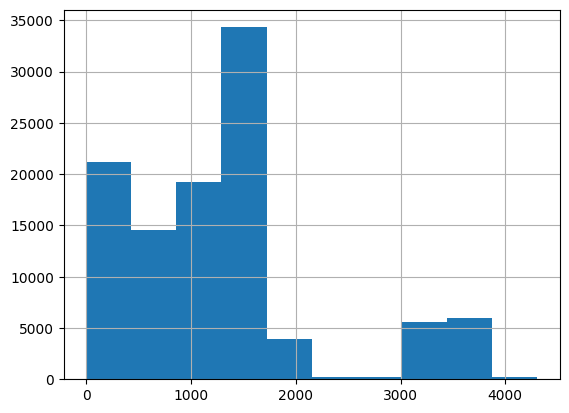

In [23]:
data["StageActiveDays"].hist()

In [129]:
data = pd.read_csv("../data/processed_data/loan_data_features.csv")
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
data[data["DefaultTarget_12m"].isnull()]

,LoanDuration,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,IncomeFromSocialWelfare,IncomeFromLeavePay,IncomeFromChildSupport,IncomeOther,IncomeTotal,ExistingLiabilities,...,UseOfLoanCategorical_Travel,UseOfLoanCategorical_Vehicle,Language_English,Language_Estonian,Language_Finnish,Language_German,Language_Other,Language_Russian,Language_Slovakian,Language_Spanish


In [140]:

data = pd.read_csv("../data/processed_data/loan_data_processed.csv", sep = ",")

/var/folders/c0/ys9pkt156rd6jxylz86_1flh0000gn/T/ipykernel_82754/1077802497.py:1: DtypeWarning: Columns (11,33,37,78,80,81,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/processed_data/loan_data_processed.csv", sep = ",")


In [153]:
data[["NewCreditCustomer",
                 "VerificationType",
                 "LoanDuration",
                 "IncomeFromPrincipalEmployer",
                 "IncomeFromPension",
                 "IncomeFromFamilyAllowance",
                 "IncomeFromSocialWelfare",
                 "IncomeFromLeavePay",
                 "IncomeFromChildSupport",
                 "IncomeOther",
                 "EmploymentDurationCurrentEmployer",
                 "IncomeTotal",
                 "Education",
                 "EmploymentStatus",
                 "ExistingLiabilities",
                 "LiabilitiesTotal",
                 "LanguageCode",
                 "Amount",
                 "Age",
                 "Interest",
                 "UseOfLoan",
                 "CreditScoreEsMicroL",
                 "AmountOfPreviousLoansBeforeLoan",
                 "PreviousEarlyRepaymentsCountBeforeLoan",
                 "PreviousRepaymentsBeforeLoan",
                 "Country",
                 "Gender",
                 "Rating",
                 "MonthlyPayment",
                 "HomeOwnershipType",
                 "NoOfPreviousLoansBeforeLoan",
                 "DefaultTarget_12m"
                 ]]

,NewCreditCustomer,VerificationType,LoanDuration,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,IncomeFromSocialWelfare,IncomeFromLeavePay,IncomeFromChildSupport,IncomeOther,...,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,PreviousRepaymentsBeforeLoan,Country,Gender,Rating,MonthlyPayment,HomeOwnershipType,NoOfPreviousLoansBeforeLoan,DefaultTarget_12m
0,False,4.0,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3402.0,0.0,1161.57,EE,1.0,D,115.34,10.0,1.0,0.0
1,False,4.0,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,518.0,0.0,525.21,FI,1.0,B,108.17,1.0,1.0,0.0
2,False,4.0,60,0.0,301.0,0.0,53.0,0.0,0.0,0.0,...,500.0,0.0,590.95,EE,1.0,C,62.05,1.0,1.0,0.0
3,False,4.0,108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11198.0,0.0,1176.22,FI,0.0,D,6.65,3.0,5.0,0.0
4,False,4.0,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8609.0,0.0,931.98,EE,0.0,C,16.67,1.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308694,False,4.0,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6373.0,0.0,592.95,EE,1.0,B,14.44,1.0,5.0,0.0
308695,False,4.0,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10630.0,0.0,190.65,EE,1.0,C,9.49,1.0,5.0,0.0
308696,False,4.0,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11159.0,0.0,2436.35,EE,0.0,C,111.58,1.0,9.0,0.0
308697,False,4.0,117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6222.0,0.0,972.44,FI,1.0,D,8.32,3.0,5.0,0.0


In [154]:
data[[
                 "Education",
                 "EmploymentStatus",
                 "ExistingLiabilities",
                 "LiabilitiesTotal",
                 "LanguageCode",
                 "Amount",
                 "Age",
                 "Interest",
                 "UseOfLoan",
                 "CreditScoreEsMicroL",
                 "AmountOfPreviousLoansBeforeLoan",
                 "PreviousEarlyRepaymentsCountBeforeLoan",
                 "PreviousRepaymentsBeforeLoan",
                 "Country",
                 "Gender",
                 "Rating",
                 "MonthlyPayment",
                 "HomeOwnershipType",
                 "NoOfPreviousLoansBeforeLoan",
                 "DefaultTarget_12m"
                 ]]

,Education,EmploymentStatus,ExistingLiabilities,LiabilitiesTotal,LanguageCode,Amount,Age,Interest,UseOfLoan,CreditScoreEsMicroL,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,PreviousRepaymentsBeforeLoan,Country,Gender,Rating,MonthlyPayment,HomeOwnershipType,NoOfPreviousLoansBeforeLoan,DefaultTarget_12m
0,3.0,-1.0,0,0.00,1,3189.0,27,35.48,-1,M,3402.0,0.0,1161.57,EE,1.0,D,115.34,10.0,1.0,0.0
1,5.0,-1.0,0,0.00,4,4146.0,35,19.86,-1,M,518.0,0.0,525.21,FI,1.0,B,108.17,1.0,1.0,0.0
2,4.0,6.0,8,485.09,1,2125.0,53,20.97,2,NaN,500.0,0.0,590.95,EE,1.0,C,62.05,1.0,1.0,0.0
3,3.0,-1.0,0,0.00,4,414.0,43,19.89,-1,M,11198.0,0.0,1176.22,FI,0.0,D,6.65,3.0,5.0,0.0
4,1.0,-1.0,0,0.00,1,531.0,25,25.27,-1,M,8609.0,0.0,931.98,EE,0.0,C,16.67,1.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308694,4.0,-1.0,0,0.00,3,531.0,38,16.22,-1,M,6373.0,0.0,592.95,EE,1.0,B,14.44,1.0,5.0,0.0
308695,4.0,-1.0,0,0.00,3,318.0,56,21.94,-1,M,10630.0,0.0,190.65,EE,1.0,C,9.49,1.0,5.0,0.0
308696,5.0,-1.0,0,0.00,3,4253.0,61,14.12,-1,M,11159.0,0.0,2436.35,EE,0.0,C,111.58,1.0,9.0,0.0
308697,3.0,-1.0,0,0.00,4,518.0,44,19.90,-1,M,6222.0,0.0,972.44,FI,1.0,D,8.32,3.0,5.0,0.0


In [144]:
data[["NewCreditCustomer",
                 "VerificationType",
                 "LoanDuration",
                 "IncomeFromPrincipalEmployer",
                 "IncomeFromPension",
                 "IncomeFromFamilyAllowance",
                 "IncomeFromSocialWelfare",
                 "IncomeFromLeavePay",
                 "IncomeFromChildSupport",
                 "IncomeOther",
                 "EmploymentDurationCurrentEmployer",
                 "IncomeTotal",
                 "Education",
                 "EmploymentStatus",
                 "ExistingLiabilities",
                 "LiabilitiesTotal",
                 "LanguageCode",
                 "Amount",
                 "Age",
                 "Interest",
                 "UseOfLoan",
                 "CreditScoreEsMicroL",
                 "AmountOfPreviousLoansBeforeLoan",
                 "PreviousEarlyRepaymentsBeforeLoan",
                 "PreviousEarlyRepaymentsCountBeforeLoan",
                 "PreviousRepaymentsBeforeLoan",
                 "Country",
                 "Gender",
                 "Rating",
                 "MonthlyPayment",
                 "HomeOwnershipType",
                 "NoOfPreviousLoansBeforeLoan",
                 "DefaultTarget_12m"
                 ]]

KeyError: "['PreviousEarlyRepaymentsBeforeLoan'] not in index"

In [125]:
def one_hot_encode_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encodes the features
    """
    encoder = OneHotEncoder(handle_unknown='ignore')
    categorical_features = df.select_dtypes(include=["category", "object"])
    non_categorical_features = df.select_dtypes(exclude=["category", "object"])
    
    # Convert all categorical features to string to handle mixed types
    categorical_features = categorical_features.astype(str)
    
    encoder.fit(categorical_features)
    encoded_features = encoder.transform(categorical_features)
    encoded_features = pd.DataFrame(encoded_features.toarray(), 
                                    columns=encoder.get_feature_names_out()
                                    )
    
    # Reset index of non-categorical features to align with the new encoded dataframe
    non_categorical_features = non_categorical_features.reset_index(drop=True)
    
    return pd.concat([non_categorical_features, encoded_features], axis=1)

In [127]:
data1 = one_hot_encode_features(data)
data1[data1["DefaultTarget_12m"].isnull()]

,LoanDuration,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,IncomeFromSocialWelfare,IncomeFromLeavePay,IncomeFromChildSupport,IncomeOther,IncomeTotal,ExistingLiabilities,...,UseOfLoanCategorical_Travel,UseOfLoanCategorical_Vehicle,Language_English,Language_Estonian,Language_Finnish,Language_German,Language_Other,Language_Russian,Language_Slovakian,Language_Spanish


In [120]:
data[data["DefaultTarget_12m"].isnull()]

,LoanDuration,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,IncomeFromSocialWelfare,IncomeFromLeavePay,IncomeFromChildSupport,IncomeOther,EmploymentDurationCurrentEmployer,IncomeTotal,...,new_customer_binary,VerificationCategorical,EducationCategorical,EmploymentCategorical,GenderCategorical,HomeOwnershipCategorical,UseOfLoanCategorical,Language,CreditScoreEsMicroLEnc,RatingEnc


In [48]:
data.columns.tolist()

['ReportAsOfEOD',
 'LoanId',
 'LoanNumber',
 'ListedOnUTC',
 'BiddingStartedOn',
 'BidsPortfolioManager',
 'BidsApi',
 'BidsManual',
 'PartyId',
 'NewCreditCustomer',
 'LoanApplicationStartedDate',
 'LoanDate',
 'ContractEndDate',
 'FirstPaymentDate',
 'MaturityDate_Original',
 'MaturityDate_Last',
 'ApplicationSignedHour',
 'ApplicationSignedWeekday',
 'VerificationType',
 'LanguageCode',
 'Age',
 'DateOfBirth',
 'Gender',
 'Country',
 'AppliedAmount',
 'Amount',
 'Interest',
 'LoanDuration',
 'MonthlyPayment',
 'County',
 'City',
 'UseOfLoan',
 'Education',
 'MaritalStatus',
 'NrOfDependants',
 'EmploymentStatus',
 'EmploymentDurationCurrentEmployer',
 'EmploymentPosition',
 'WorkExperience',
 'OccupationArea',
 'HomeOwnershipType',
 'IncomeFromPrincipalEmployer',
 'IncomeFromPension',
 'IncomeFromFamilyAllowance',
 'IncomeFromSocialWelfare',
 'IncomeFromLeavePay',
 'IncomeFromChildSupport',
 'IncomeOther',
 'IncomeTotal',
 'ExistingLiabilities',
 'LiabilitiesTotal',
 'RefinanceLiabi

### Lets capture Default Loans

#### Exposure and Balance features

In [59]:
exposure_features = ["EAD2", "EAD1", "InterestAndPenaltyBalance", "PrincipalBalance", "Amount", "LoanDuration"]

#### Default Severity

In [60]:
severity_features = ["CurrentDebtDaysPrimary", "CurrentDebtDaysSecondary", "ActiveLateCategory", "WorseLateCategory"]

### Recovery Process

In [82]:
recovery_features = ["RecoveryStage", "DebtOccuredOn","DebtOccuredOnForSecondary"]

### Servicing Cost

In [83]:
servicing_features = ["PrincipalDebtServicingCost", "InterestAndPenaltyDebtServicingCost"]

### Collection behavior

In [84]:
collection_features = ["StageActiveSince", "DebtOccuredOn", "DebtOccuredOnForSecondary"]

In [85]:
# Capture only defaulted loans
defaulted_loans = data[~data["DefaultDate"].isnull()]

In [86]:
feature_data = defaulted_loans[exposure_features + severity_features + recovery_features + servicing_features + collection_features]

In [87]:
feature_data.isnull().sum()

EAD2                                       3
EAD1                                       3
InterestAndPenaltyBalance              22239
PrincipalBalance                           0
Amount                                     0
LoanDuration                               0
CurrentDebtDaysPrimary                  5446
CurrentDebtDaysSecondary                3643
ActiveLateCategory                      5446
WorseLateCategory                         15
RecoveryStage                          14460
DebtOccuredOn                           5446
DebtOccuredOnForSecondary               3643
PrincipalDebtServicingCost             31176
InterestAndPenaltyDebtServicingCost    31176
StageActiveSince                        2404
DebtOccuredOn                           5446
DebtOccuredOnForSecondary               3643
dtype: int64

In [104]:
feature_data["RecoveryStage"].value_counts()

RecoveryStage
2.0    75922
3.0    10347
1.0     9486
Name: count, dtype: int64

### Lets create a strategy for those nulls

In [97]:
zero_fill = [
    "PrincipalDebtServicingCost",
    "InterestAndPenaltyDebtServicingCost",
    "InterestAndPenaltyBalance",
    "CurrentDebtDaysPrimary",
    "CurrentDebtDaysSecondary"
]

feature_data[zero_fill] = feature_data[zero_fill].fillna(0)

feature_data.isnull().sum()

impute_median = [
    "EAD1",
    "EAD2"
]

feature_data[impute_median] = feature_data[impute_median].fillna(feature_data[impute_median].median())


/var/folders/c0/ys9pkt156rd6jxylz86_1flh0000gn/T/ipykernel_82754/4136928683.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data[zero_fill] = feature_data[zero_fill].fillna(0)
/var/folders/c0/ys9pkt156rd6jxylz86_1flh0000gn/T/ipykernel_82754/4136928683.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data[impute_median] = feature_data[impute_median].fillna(feature_data[impute_median].median())


In [98]:
feature_data["HasPrimaryArrears"] = (feature_data["CurrentDebtDaysPrimary"] > 0).astype(int)

/var/folders/c0/ys9pkt156rd6jxylz86_1flh0000gn/T/ipykernel_82754/2755846699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data["HasPrimaryArrears"] = (feature_data["CurrentDebtDaysPrimary"] > 0).astype(int)


In [99]:
feature_data.isnull().sum()

EAD2                                       0
EAD1                                       0
InterestAndPenaltyBalance                  0
PrincipalBalance                           0
Amount                                     0
LoanDuration                               0
CurrentDebtDaysPrimary                     0
CurrentDebtDaysSecondary                   0
ActiveLateCategory                      5446
WorseLateCategory                         15
RecoveryStage                          14460
DebtOccuredOn                           5446
DebtOccuredOnForSecondary               3643
PrincipalDebtServicingCost                 0
InterestAndPenaltyDebtServicingCost        0
StageActiveSince                        2404
DebtOccuredOn                           5446
DebtOccuredOnForSecondary               3643
HasPrimaryArrears                          0
dtype: int64

In [103]:
feature_data["Lass"].value_counts()

WorseLateCategory
180        99805
121-150     2523
151-180     2430
91-120      2220
61-90       1615
31-60       1064
16-30        311
8-15         138
1-7           94
Name: count, dtype: int64

In [94]:
feature_data["CurrentDebtDaysPrimary"].value_counts()

CurrentDebtDaysPrimary
1440.0    605
1349.0    412
1258.0    405
1531.0    320
1286.0    287
         ... 
3188.0      1
3596.0      1
3000.0      1
3159.0      1
2664.0      1
Name: count, Length: 2438, dtype: int64